In [1]:
import os
import sys
sys.path.append('./code/')

from utils import *
from DataGenerator import DataGenerator

## Reading Data

In [2]:
image_path = 'Flickr30k/images/'
data = pd.read_csv("Flickr30k/captions.txt")
data.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,Two young White males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## Visualization

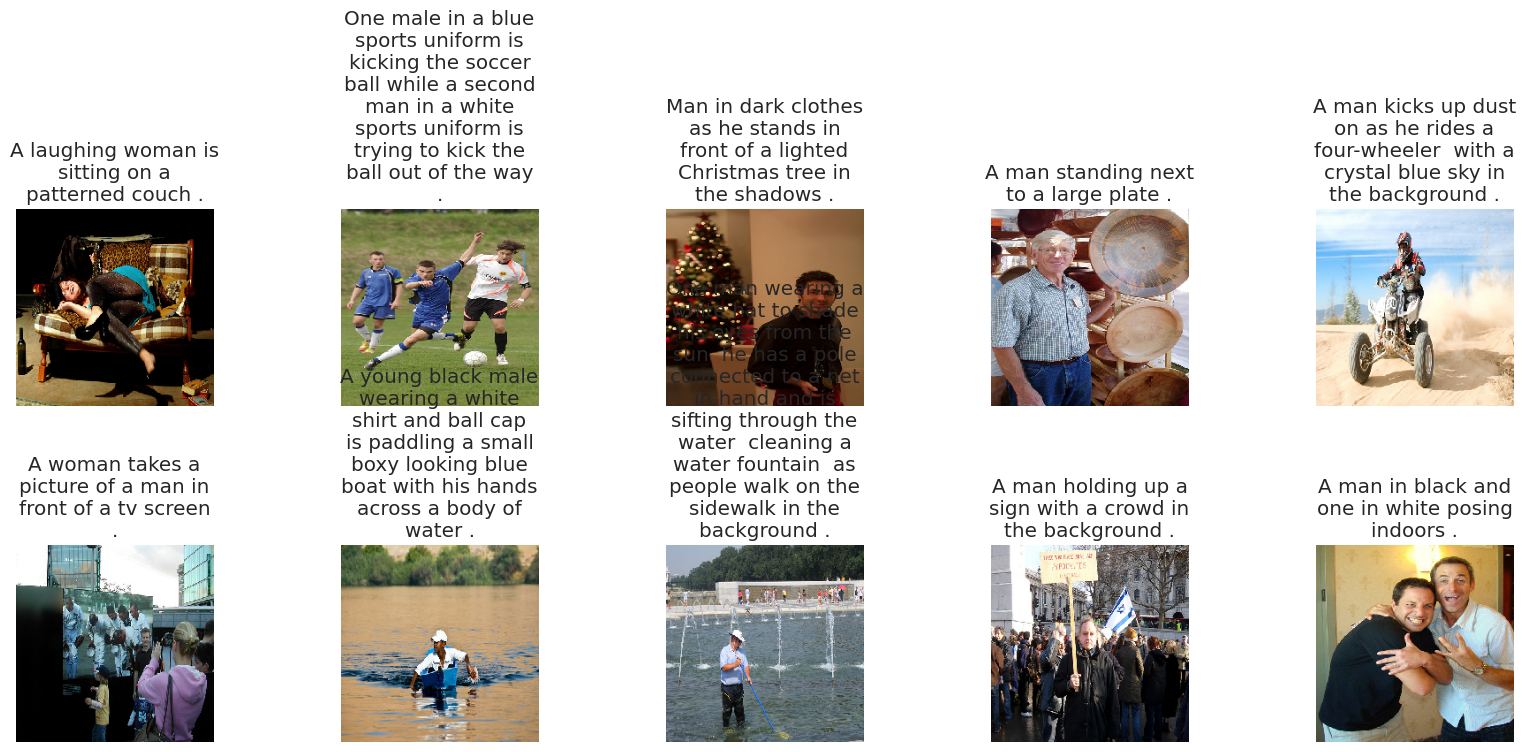

In [3]:
display_images(data.sample(10), path_image = image_path)

## Caption pre-processing

In [4]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:5]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

## Tokenization and Encoded Representation

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

## Train-test split

In [6]:
images = data['image'].unique().tolist()
split_index_val = round(0.80 * len(images))

train_images = images[ : split_index_val]
val_images = images[split_index_val : split_index_val + int(0.15 * split_index_val)]
test_images = images[split_index_val + int(0.15 * split_index_val) : ]

train = data[data['image'].isin(train_images)]
train.reset_index(inplace = True, drop = True)

test = data[data['image'].isin(val_images)]
test.reset_index(inplace = True, drop = True)

holdout = data[data['image'].isin(test_images)]
holdout.reset_index(inplace = True, drop = True)

## Image Feature Extraction

In [7]:
model = VGG16()
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image), target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
    # print(feature.shape)
    # break

  0%|          | 0/31764 [00:00<?, ?it/s]

## Modelling

In [8]:
input1 = Input(shape = (4096, ))
img_features = Dense(3000, activation = 'relu')(input1)
img_features1 = Dense(512, activation = 'relu')(img_features)
img_features_reshaped = Reshape((1, 512), input_shape = (512,))(img_features1)

input2 = Input(shape = (max_length, ))
sentence_features = Embedding(vocab_size, 512)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis = 1)

sentence_features = LSTM(512)(merged)
x = Dropout(0.2)(sentence_features)
x = add([x, img_features1])
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)

output = Dense(vocab_size, activation = 'softmax')(x)

caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [9]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 3000)         12291000    ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          1536512     ['dense[0][0]']                  
                                                                                                  
 input_3 (InputLayer)           [(None, 74)]         0           []                               
                                                                                            

In [10]:
from tensorflow.keras.utils import plot_model

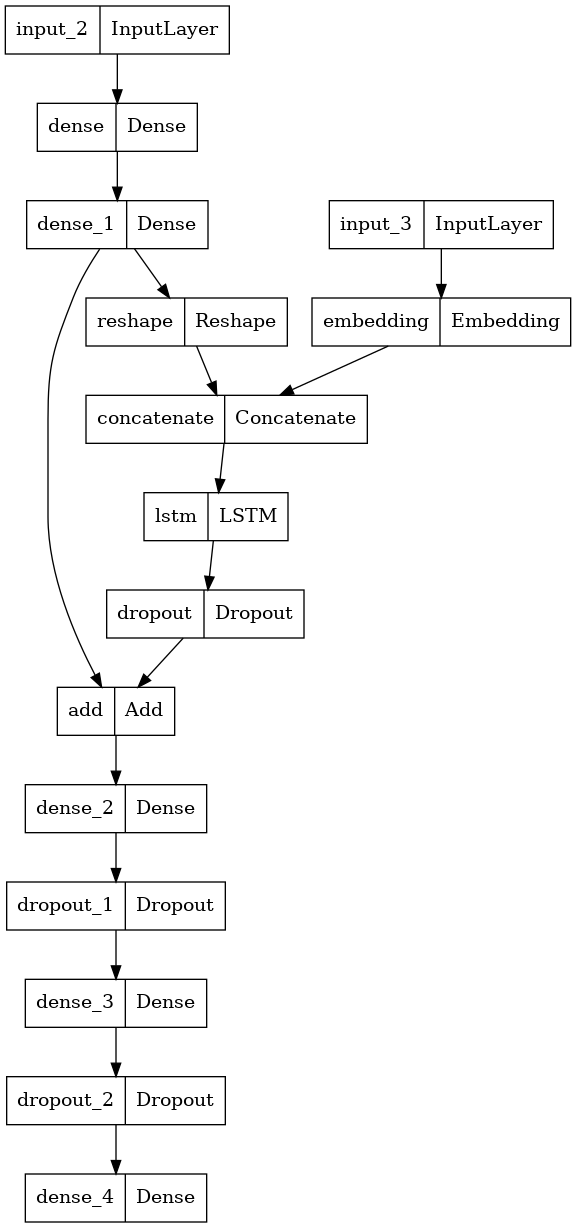

In [11]:
plot_model(caption_model)

In [12]:
train_generator = DataGenerator(df = train, X_col = 'image', y_col = 'caption', 
                                      batch_size = 32, directory = image_path,
                                      tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

validation_generator = DataGenerator(df = test, X_col = 'image', y_col = 'caption',
                                       batch_size = 32, directory = image_path,
                                       tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

In [13]:
model_name = "BaselineModel_finalfinal_30k.h5"

checkpoint = ModelCheckpoint(model_name, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose = 1, factor = 0.2, min_lr = 0.00000001)

In [14]:
history = caption_model.fit(
                train_generator, 
                epochs = 30, 
                validation_data = validation_generator,
                callbacks = [checkpoint, earlystopping, learning_rate_reduction]
          )

Epoch 1/30
3970/3970 [==============================] - ETA: 0s - loss: 4.4026
Epoch 1: val_loss improved from inf to 4.18095, saving model to BaselineModel_finalfinal_30k.h5
3970/3970 [==============================] - 1052s 264ms/step - loss: 4.4026 - val_loss: 4.1809 - lr: 0.0010
Epoch 2/30
3970/3970 [==============================] - ETA: 0s - loss: 3.7524
Epoch 2: val_loss improved from 4.18095 to 3.98193, saving model to BaselineModel_finalfinal_30k.h5
3970/3970 [==============================] - 245s 62ms/step - loss: 3.7524 - val_loss: 3.9819 - lr: 0.0010
Epoch 3/30
3970/3970 [==============================] - ETA: 0s - loss: 3.5513
Epoch 3: val_loss improved from 3.98193 to 3.93866, saving model to BaselineModel_finalfinal_30k.h5
3970/3970 [==============================] - 242s 61ms/step - loss: 3.5513 - val_loss: 3.9387 - lr: 0.0010
Epoch 4/30
3970/3970 [==============================] - ETA: 0s - loss: 3.4252
Epoch 4: val_loss improved from 3.93866 to 3.92028, saving model 

## Learning Curve

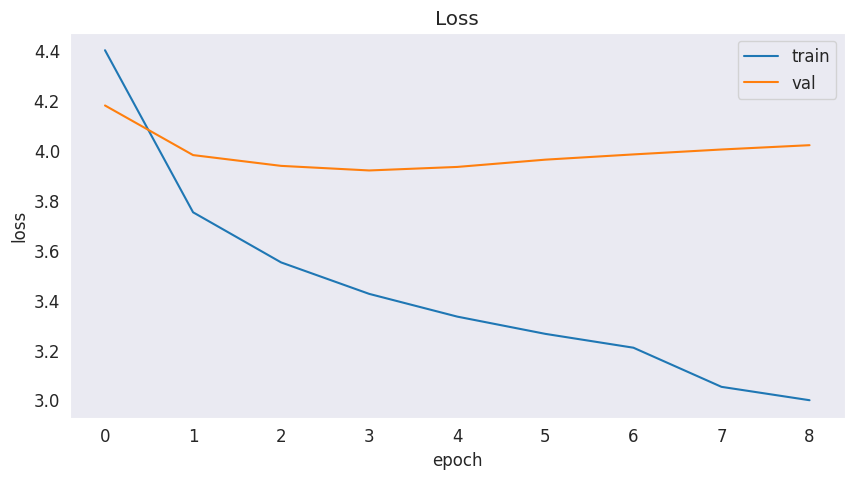

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Caption Generation 

In [16]:
def get_predictions_baseline(sample_size, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features, verbosity = 0):
    
    if(len(test) < sample_size):
        samples = test.sample(sample_size, replace = True)
    else:    
        samples = test.sample(sample_size, replace = False)

    samples.reset_index(drop=True,inplace=True)

    for index,record in samples.iterrows():
        img = load_img(os.path.join(image_path, record['image']),target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        caption = predict_caption(caption_model, record['image'], 
                                  tokenizer, max_length, features, verbosity)
        samples.loc[index,'caption'] = caption

    display_images(samples, image_path)

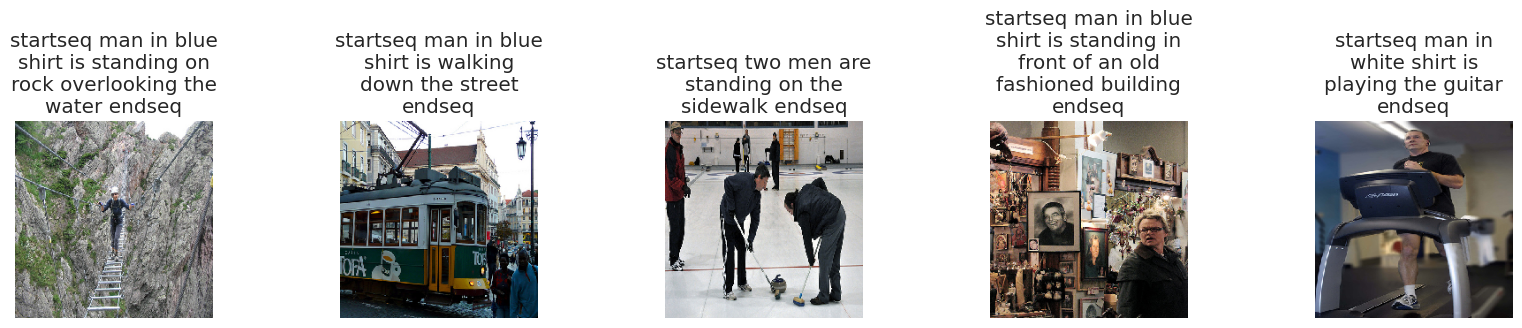

In [17]:
get_predictions_baseline(5, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features)